In [ ]:
import pandas as pd

test1 = pd.read_csv('/content/Test1.csv')
test2 = pd.read_csv('/content/test2.csv')
test3 = pd.read_csv('/content/test3.csv')
train1 = pd.read_csv('/content/Training1.csv')
train2 = pd.read_csv('/content/Training2.csv')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from scipy.interpolate import interp1d
signal1=test1['velocity(c/s)']
signal2=test2['velocity(c/s)']
signal3=test3['velocity(c/s)']
signal4=train1['velocity(c/s)']
signal5=train2['velocity(c/s)']
time1=test1['rel_time(sec)']
time2=test2['rel_time(sec)']
time3=test3['rel_time(sec)']
time4=train1['rel_time(sec)']
time5=train2['rel_time(sec)']


Processing signal 1...
Processing signal 2...


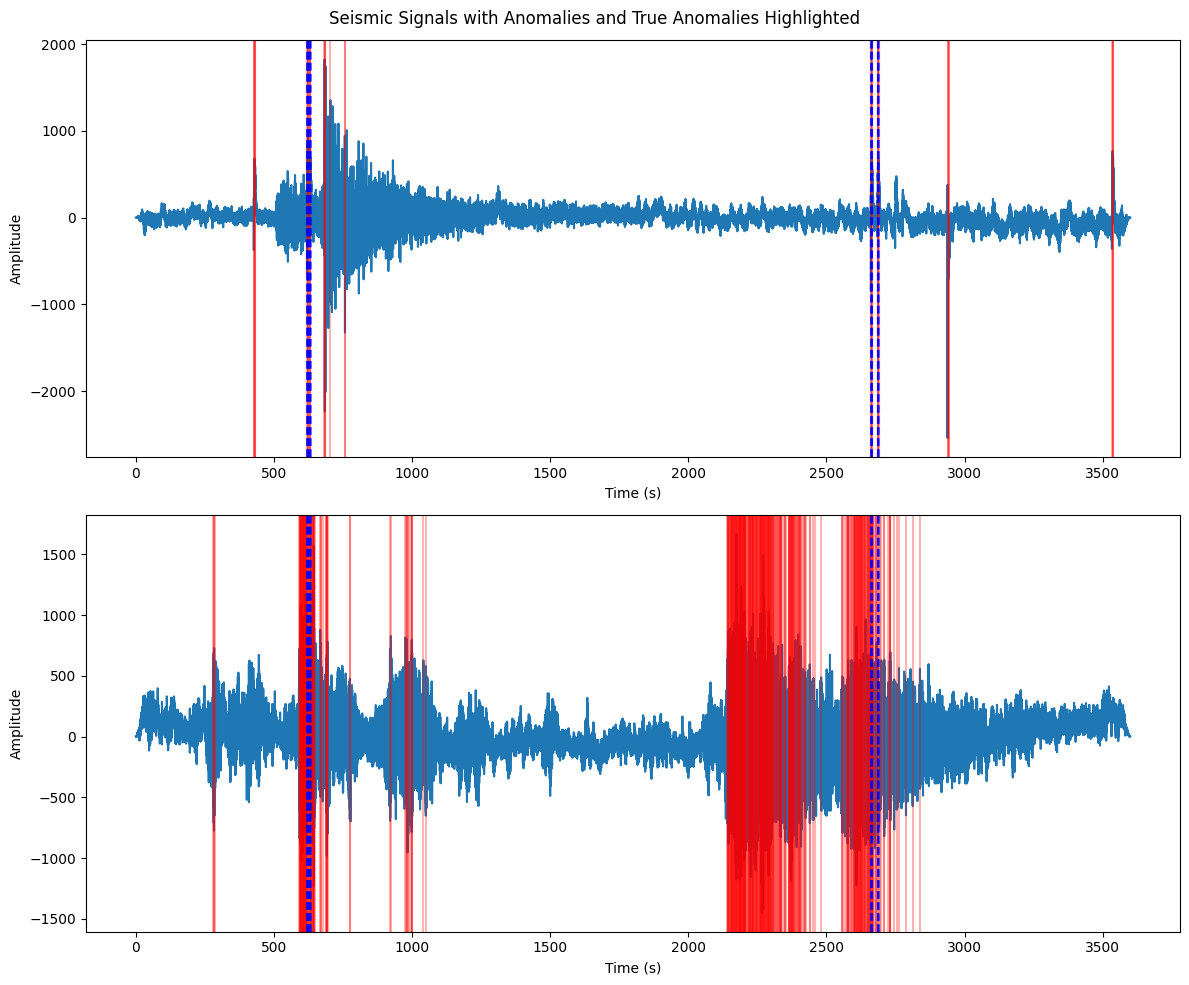

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


def extract_features(signal, time_array, window_size):
    features = []
    segment_times = []

    time_diffs = np.diff(time_array)
    avg_fs = 1 / np.mean(time_diffs)
    n_samples = int(window_size * avg_fs)

    for i in range(0, len(signal) - n_samples + 1, n_samples):
        segment = signal[i:i + n_samples]
        segment_time = time_array[i]

        mean = np.mean(segment)
        std = np.std(segment)

        fft_segment = np.fft.fft(segment)
        power_spectrum = np.abs(fft_segment[:len(fft_segment) // 2])**2
        low_power = np.sum(power_spectrum[:int(len(power_spectrum) * 0.1)])
        high_power = np.sum(power_spectrum[int(len(power_spectrum) * 0.1):])
        features.append([mean, std, low_power, high_power])
        segment_times.append(segment_time)

    return np.array(features), np.array(segment_times)


signals = [ signal4, signal5]
time_arrays = [ time4, time5]

window_size = 1.0
all_anomalies = []

for idx, (signal, time_arr) in enumerate(zip(signals, time_arrays)):
    print(f"Processing signal {idx + 1}...")

    features, segment_times = extract_features(signal, time_arr, window_size)


    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters, random_state=5)
    clusters = kmeans.fit_predict(features)

    cluster_sizes = np.bincount(clusters)
    anomoly_cluster = np.argmin(cluster_sizes)  # The largest cluster is assumed normal

    # Store anomaly locations
    anomalies = []
    for i in range(len(clusters)):
        if clusters[i] == anomoly_cluster:  # Anomalous cluster(s)
            anomalies.append(segment_times[i])  # Store time instead of index

    all_anomalies.append(anomalies)

time_tolerance = 1.0  # 1-second tolerance for matching anomalies
common_anomalies = []

# Flatten all anomalies into a single list with source signal indices
flattened_anomalies = [(t, i) for i, anomaly_list in enumerate(all_anomalies) for t in anomaly_list]

# Compare anomalies from different signals
for i, (t1, idx1) in enumerate(flattened_anomalies):
    count = 1  # Count how many signals have an anomaly at this time
    for j, (t2, idx2) in enumerate(flattened_anomalies):
        if i != j and idx1 != idx2 and abs(t1 - t2) <= time_tolerance:
            count += 1
    if count >= 2:  # If the anomaly is found in at least two signals, mark as true anomaly
        common_anomalies.append(t1)

common_anomalies = sorted(set(common_anomalies))  # Remove duplicates
num_signals = len(signals)
# Plot all signals with anomaly highlighting
plt.figure(figsize=(12, 10))
for idx, (signal, time_arr) in enumerate(zip(signals, time_arrays)):
    plt.subplot(num_signals, 1, idx + 1)
    plt.plot(time_arr, signal, label=f"Signal {idx + 1}")

    # Highlight anomalies in red
    for t in all_anomalies[idx]:
        plt.axvline(x=t, color='red', alpha=0.3, label="Anomaly" if idx == 0 else None)

    # Highlight common anomalies in blue
    for t in common_anomalies:
        plt.axvline(x=t, color='blue', alpha=0.5, linestyle='--', label="True Anomaly" if idx == 0 else None)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")


plt.suptitle("Seismic Signals with Anomalies and True Anomalies Highlighted")
plt.tight_layout()
plt.show()

